# AYA Project

Les donnees proviennent de plusieurs sources:
* Leucegene:
500 patients dont 80 AYA
donnees:  p-value analyse expression differentielle
non normalise 
analyse avec DeSeq2
* TGCA: ~ 200 adultes
* Target (https://ocg.cancer.gov/programs/target/projects/acute-myeloid-leukemia):
Les chercheurs de TARGET analysent les tumeurs de patients pediatriques, dont beaucoup ont fait une rechute, afin d'identifier des biomarqueurs en correlation avec de mauvais resultats cliniques et / ou de nouvelles approches therapeutiques pour traiter la LMA chez l'enfant. (200 patients)


But : Analyse expression differentielle, mettre en evidence des genes specifique aux Adolescents et jeunes Adultes (18-40 ans).



In [11]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("DESeq2", version = "3.8")
library("DESeq2")
#BiocManager::install("genefilter", version = "3.8")
library(genefilter)

In [12]:
library('plyr') #package pour table de comptage
library(magrittr)
library("varhandle")
#library(tidyr)

### SOUS GROUPE ADVERSE

### DE complex vs other subgroup

In [13]:
data_API = read.csv("/home/safia/Documents/AYA/Leucegene risk complete.txt",header = T,sep = "\t")
data_API<- data.frame(data_API[,-1], row.names=data_API[,1])

t_data_API = as.data.frame(t(data_API)) # inverse colonne ligne
colnames(t_data_API) <- gsub(" ","_",colnames(t_data_API)) # remplace les espaces dans le nom des colonnes
t_data_API <- head(t_data_API, -1) # supprimme la deriniere ligne data_type 

inf_40 = t_data_API[which(as.integer(t_data_API$Age_at_diagnosis)<=40),]
data_AYA = inf_40[which(as.integer(inf_40$Age_at_diagnosis)>=18),]
data_AYA = data_AYA[which(unfactor(data_AYA$`blasts_(%)`)>=70),]

In [14]:
adverse = row.names(data_AYA[which(unfactor(data_AYA$cytogenetic_risk)=="adverse cytogenetics"),])
API_Adv = data_AYA[which(rownames(data_AYA) %in% adverse),]
count_Adv_subgroup = count(API_Adv, "cytogenetic_subgroup")

In [15]:
complex = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[1]),])

mll = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[3]),])

m5_m7 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[4]),])

m17 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[5]),])

t6_9 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[6]),])

Warning message:
“Unknown or uninitialised column: 'cytogenetic_subgroup'.”Warning message:
“Unknown or uninitialised column: 'cytogenetic_subgroup'.”Warning message:
“Unknown or uninitialised column: 'cytogenetic_subgroup'.”Warning message:
“Unknown or uninitialised column: 'cytogenetic_subgroup'.”Warning message:
“Unknown or uninitialised column: 'cytogenetic_subgroup'.”

In [16]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")

read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)

In [17]:
library("tidyr")
library("dplyr")
library("ggplot2")

In [18]:
mll = substring(mll,2)
count_mll = read_count[,mll]
colnames(count_mll) = paste("MLL", colnames(count_mll), sep = "_")

complex = substring(complex,2)
count_complex = read_count[,complex]
colnames(count_complex) = paste("Cpx", colnames(count_complex), sep = "_")


m5_m7 = substring(m5_m7,2)
count_m5_m7 = read_count[,m5_m7]
colnames(count_m5_m7) = paste("M57", colnames(count_m5_m7), sep = "_")


t6_9 = substring(t6_9,2)
count_t6_9 = read_count[,t6_9]
colnames(count_t6_9) = paste("t69", colnames(count_t6_9), sep = "_")


ERROR: Error in names(x) <- value: 'names' attribute [1] must be the same length as the vector [0]


In [ ]:
df_IF = cbind(count_complex,count_mll,count_m5_m7,count_t6_9)


samples_IF <- data.frame(groups = substr(colnames(df_IF), 1, 3))


ds_IF <- DESeqDataSetFromMatrix(countData=df_IF, colData=samples_IF, design=~groups)
colnames(ds_IF) <- colnames(counts)
ds_IF <-DESeq(ds_IF)
res_IF <- results(ds_IF)


res <- results(ds_IF, tidy=TRUE) %>%
  arrange(padj, pvalue) %>%
  tbl_df()
head(res)

goi <- res$row[1:9]
stopifnot(all(goi %in% names(ds_IF)))


tcounts <- t(log2((counts(ds_IF[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(ds_IF), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))

head(tcounts)

library('biomaRt')
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
genes <- tcounts$gene
genes <- gsub("\\..*","",genes )
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id",
"hgnc_symbol"),values=genes,mart= mart)
for (i in 1:length(genes)){
    if (genes[i] %in% G_list$ensembl_gene_id){
        a = G_list[G_list$ensembl_gene_id == genes[i],]$hgnc_symbol
        if (a != ""){
            tcounts$gene[i] = a
        }
         
    }
}

ggplot(tcounts, aes(groups, expression, fill=groups)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Cytogenetic risk", 
       y="Expression (log normalized counts)", 
       fill="Cytogenetic risk", 
       title="Top 9 Results")


In [ ]:
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
genes <- res$row
genes <- gsub("\\..*","",genes )
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id",
                                                          "hgnc_symbol"),values=genes,mart= mart)
for (i in 1:length(genes)){
  if (genes[i] %in% G_list$ensembl_gene_id){
    a = G_list[G_list$ensembl_gene_id == genes[i],]$hgnc_symbol
    if (a != ""){
      res$row[i] = a
    }
    
  }
}

res_mart = res[,c(1,3,7)]
colnames(res_mart)= c("Gene.symbol","logFC","adj.P.Val")

res_mart_na = as.data.frame(na.omit(res_mart))
res_mart_na$adj.P.Val = as.numeric(as.character(res_mart_na$adj.P.Val))

suppressPackageStartupMessages(library(pathfindR))

knitr::kable(head(res_mart_na))
RA_output <- run_pathfindR(res_mart_na, pin_name = "KEGG", gene_sets = "KEGG")
#RA_output <- run_pathfindR(res_mart_na, pin_name = "KEGG", gene_sets = "KEGG", search_method = "SA") # recuit simulé = resultats enrichissement differents a chaque fois 
knitr::kable(head(RA_output, 2))

RA_clustered <- cluster_pathways(RA_output)
knitr::kable(head(RA_clustered, 2))
knitr::kable(RA_clustered[RA_clustered$Status == "Representative", ])
RA_clustered <- cluster_pathways(RA_output, plot_hmap = TRUE, plot_clusters_graph = FALSE)
RA_clustered <- cluster_pathways(RA_output, plot_dend = TRUE, plot_clusters_graph = FALSE)

## Pathway scores per samples
## Pathway data frame
pws_table <- RA_clustered
pws_table <- pws_table[pws_table$Status == "Representative", ]


## Expression matrix
  goi <- rownames(res_IF)
stopifnot(all(goi %in% names(ds_IF)))
exp_mat <- log2((counts(ds_IF[goi, ], normalized=TRUE, replaced=FALSE)+.5))

colnames(exp_mat) = colnames(df_IF)

mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
genes <- rownames(exp_mat)
genes <- gsub("\\..*","",genes )
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id",
                                                          "hgnc_symbol"),values=genes,mart= mart)
for (i in 1:length(genes)){
  if (genes[i] %in% G_list$ensembl_gene_id){
    a = G_list[G_list$ensembl_gene_id == genes[i],]$hgnc_symbol
    if (a != ""){
      rownames(exp_mat)[i] = a
    }
    
  }
}



## Vector of "Case" IDs
cases <- colnames(count_complex)

## Calculate pathway scores and plot heatmap
score_matrix <- calculate_pw_scores(pws_table, exp_mat, cases, case_control_titles = c("Complex", "Other"))


### Clustering adverse

In [12]:
adverse = substring(adverse,2)
#adverse = adverse[adverse != "08H085"]
#adverse = adverse[adverse != "01H001"]

In [13]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")

read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)
count_adverse = read_count[,adverse]

In [14]:
cohort_IQR = apply(count_adverse,1,IQR)
rank_cohort_IQR = rank(cohort_IQR)
ordered_data=count_adverse[order(-rank_cohort_IQR),]
tordered_data=t(ordered_data)

In [15]:
library(cluster)
library(dplyr)
library(ggplot2)
library(readr)
library(Rtsne)
library(ISLR) # for college dataset


Attaching package: ‘readr’

The following object is masked from ‘package:genefilter’:

    spec



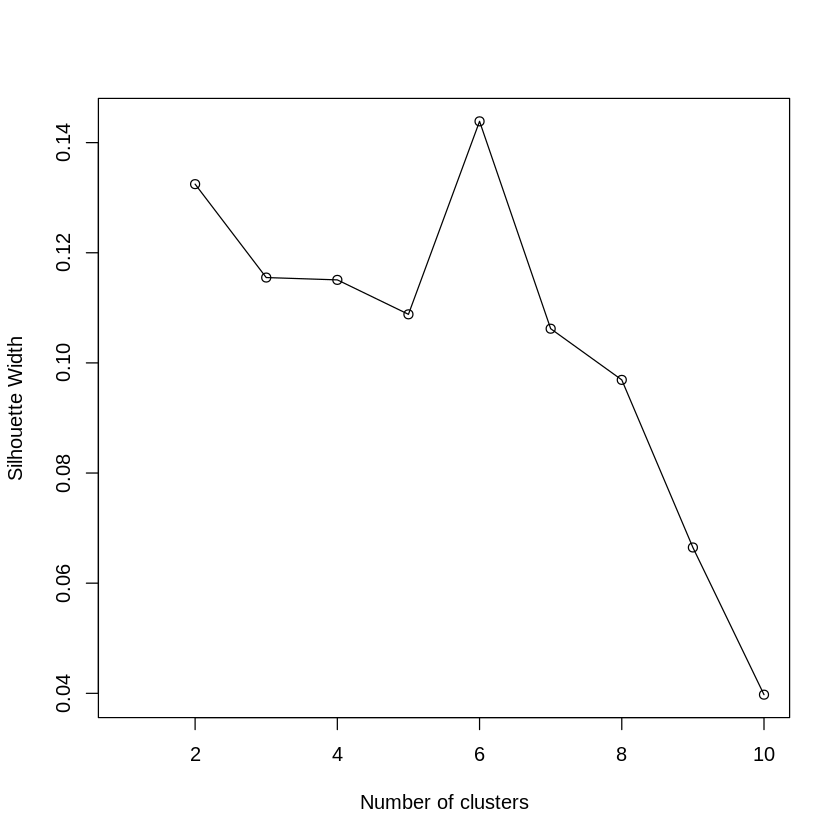

In [16]:
gower_dist <- daisy(tordered_data[,c(1:500)],
                    metric = "gower",
                    type = list(logratio = 3))

gower_mat <- as.matrix(gower_dist)
# Calculate silhouette width for many k using PAM

sil_width <- c(NA)

for(i in 2:10){
  
  pam_fit <- pam(gower_dist,
                 diss = TRUE,
                 k = i)
  
  sil_width[i] <- pam_fit$silinfo$avg.width
  
}

# Plot sihouette width (higher is better)

plot(1:10, sil_width,
     xlab = "Number of clusters",
     ylab = "Silhouette Width")
lines(1:10, sil_width)


In [19]:
library(factoextra)
for (i in 2:10){
    pam_fit <- pam(gower_dist, diss = TRUE, k = i)
    fviz_silhouette(silhouette(pam_fit))
}

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


  cluster size ave.sil.width
1       1    6          0.12
2       2    9          0.14
  cluster size ave.sil.width
1       1    5         -0.01
2       2    3          0.10
3       3    7          0.21
  cluster size ave.sil.width
1       1    4          0.05
2       2    3          0.07
3       3    7          0.19
4       4    1          0.00
  cluster size ave.sil.width
1       1    1          0.00
2       2    3          0.03
3       3    7          0.13
4       4    3          0.20
5       5    1          0.00
  cluster size ave.sil.width
1       1    1          0.00
2       2    2          0.20
3       3    6          0.15
4       4    2          0.19
5       5    3          0.17
6       6    1          0.00
  cluster size ave.sil.width
1       1    1          0.00
2       2    2          0.19
3       3    5          0.07
4       4    2          0.19
5       5    3          0.16
6       6    1          0.00
7       7    1          0.00
  cluster size ave.sil.width
1       1    1

#### K = 3

  cluster size ave.sil.width
1       1    5         -0.01
2       2    3          0.10
3       3    7          0.21


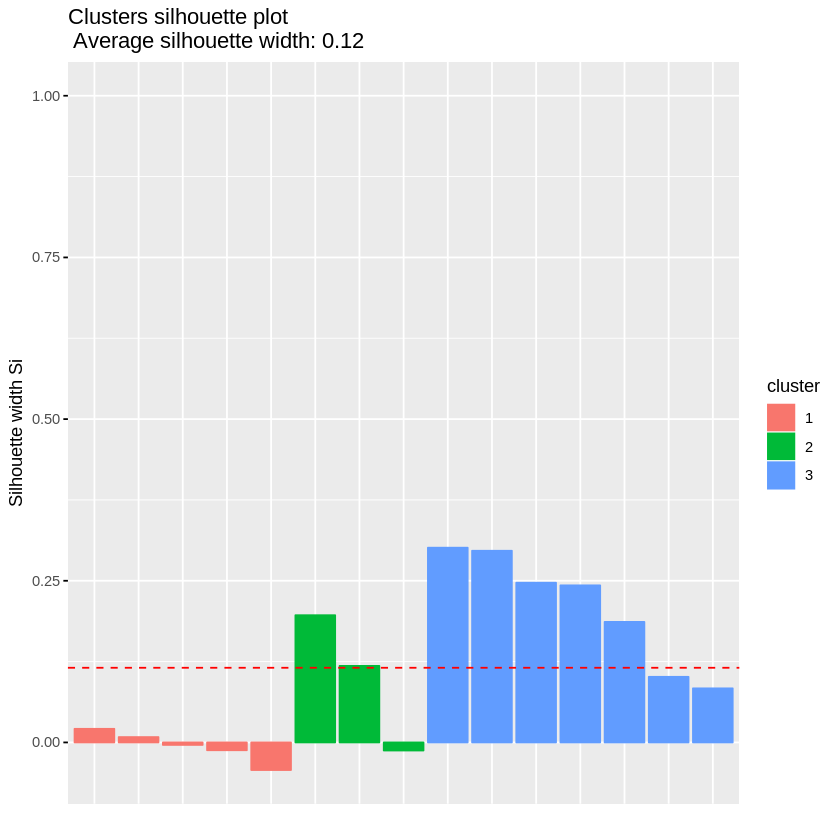

In [20]:
pam_fit <- pam(gower_dist, diss = TRUE, k = 3)

fviz_silhouette(silhouette(pam_fit)) 


In [31]:
df_IF = count_adverse

samples_IF <-  data.frame(groups = as.character(as.vector(pam_fit$clustering)))

ds_IF <- DESeqDataSetFromMatrix(countData=df_IF, colData=samples_IF, design=~groups)
ds_IF <-DESeq(ds_IF)
res_IF <- results(ds_IF)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1271 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [32]:
res <- results(ds_IF, tidy=TRUE) %>%
  arrange(padj, pvalue) %>%
  tbl_df()
head(res)

goi <- res$row[1:9]
stopifnot(all(goi %in% names(ds_IF)))
goi

library(tidyr)

tcounts <- t(log2((counts(ds_IF[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(ds_IF), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))

head(tcounts)



row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000225492.6,149.53954,6.275513,0.8100671,7.746906,9.415878e-15,1.566929e-10
ENSG00000130054.4,71.09943,23.076097,2.9859078,7.728335,1.089621e-14,1.566929e-10
ENSG00000184838.14,998.84321,-9.881197,1.4628419,-6.754795,1.430376e-11,1.371301e-07
ENSG00000138135.6,584.16004,-9.447011,1.4076241,-6.711316,1.928764e-11,1.386830e-07
ENSG00000279166.1,131.28784,-3.196050,0.4865112,-6.569326,5.054353e-11,2.907365e-07
ENSG00000188171.15,262.73824,5.047039,0.7800144,6.470444,9.771564e-11,4.133800e-07


[1] "ENSG00000225492.6"  "ENSG00000130054.4"  "ENSG00000184838.14"
[4] "ENSG00000138135.6"  "ENSG00000279166.1"  "ENSG00000188171.15"
[7] "ENSG00000259678.1"  "ENSG00000108018.15" "ENSG00000204740.9"

Row.names,groups,sizeFactor,replaceable,gene,expression
01H001,1,1.0754568,FALSE,ENSG00000225492.6,2.8091803
02H017,2,0.7148424,FALSE,ENSG00000225492.6,3.1527446
03H036,3,1.2641438,TRUE,ENSG00000225492.6,6.0478239
03H067,2,1.2502889,FALSE,ENSG00000225492.6,3.4459381
04H054,3,0.8271376,TRUE,ENSG00000225492.6,3.7864788
04H120,1,1.1316504,FALSE,ENSG00000225492.6,0.4684948


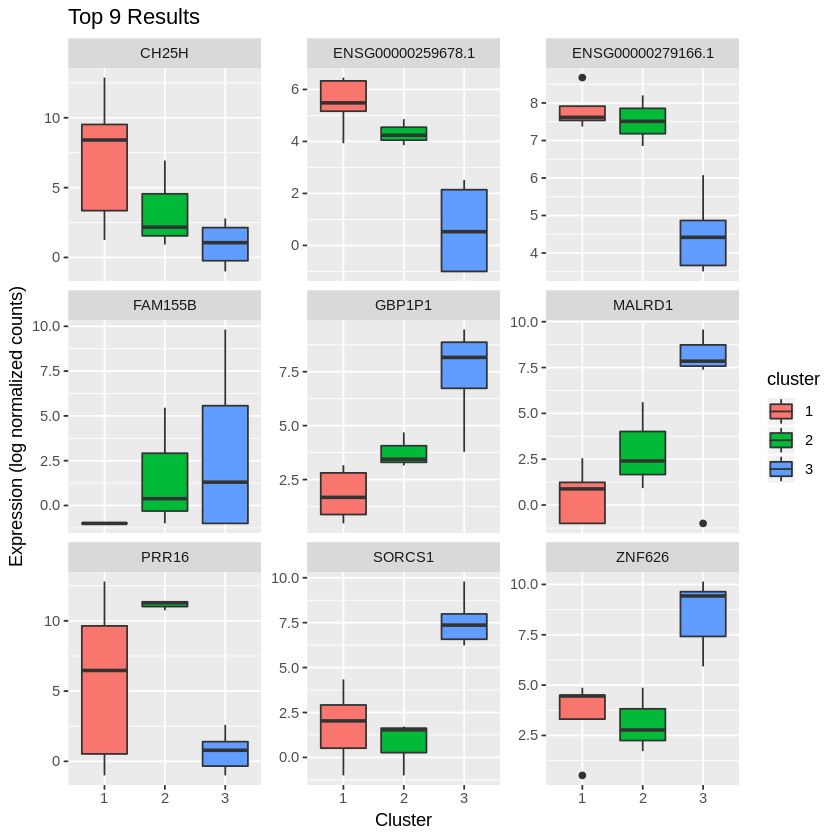

In [33]:
library(ggsignif)
library("biomaRt")

mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
genes <- tcounts$gene
genes <- gsub("\\..*","",genes )
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id",
"hgnc_symbol"),values=genes,mart= mart)
for (i in 1:length(genes)){
    if (genes[i] %in% G_list$ensembl_gene_id){
        a = G_list[G_list$ensembl_gene_id == genes[i],]$hgnc_symbol
        if (a != ""){
            tcounts$gene[i] = a
        }
         
    }
}
ggplot(tcounts, aes(groups, expression, fill=groups)) + 
  geom_boxplot()+ 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Cluster", 
       y="Expression (log normalized counts)", 
       fill="cluster", 
       title="Top 9 Results")


Warning message in if (a != "") {:
“the condition has length > 1 and only the first element will be used”Warning message in res$row[i] <- a:
“number of items to replace is not a multiple of replacement length”Warning message in if (a != "") {:
“the condition has length > 1 and only the first element will be used”Warning message in res$row[i] <- a:
“number of items to replace is not a multiple of replacement length”Warning message in if (a != "") {:
“the condition has length > 1 and only the first element will be used”Warning message in res$row[i] <- a:
“number of items to replace is not a multiple of replacement length”



|Gene.symbol       |     logFC| adj.P.Val|
|:-----------------|---------:|---------:|
|GBP1P1            |  6.275513|     0e+00|
|FAM155B           | 23.076097|     0e+00|
|PRR16             | -9.881197|     1e-07|
|CH25H             | -9.447011|     1e-07|
|ENSG00000279166.1 | -3.196051|     3e-07|
|ZNF626            |  5.047039|     4e-07|

Warning message in run_pathfindR(res_mart_na, pin_name = "KEGG", gene_sets = "KEGG"):
“There already is a directory named "pathfindR_Results".
Writing the result to "pathfindR_Results(7)" not to overwrite the previous results.”## Testing input


The input looks OK


## Processing input. Converting gene symbols, if necessary (and if human gene symbols provied)


Could not find any interactions for 2000 (83.68%) genes in the PIN


## Performing Active Subnetwork Search and Enrichment

## Processing the enrichment results over all iterations 


## Annotating involved genes and visualizing pathways


'select()' returned 1:many mapping between keys and columns
Info: Downloading xml files for hsa04062, 1/1 pathways..
Info: Downloading png files for hsa04062, 1/1 pathways..
'select()' returned 1:1 mapping between keys and columns
Info: Working in directory /home/safia/Documents/AYA_project/pathfindR_Results(7)/pathway_visualizations
Info: Writing image file hsa04062.Chemokine signaling pathwa

  |......................                                           |  33%
   inline R code fragments

  |...........................................                      |  67%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |.................................................................| 100%
  ordinary text without R code




output file: results.knit.md



/home/safia/anaconda3/bin/pandoc +RTS -K512m -RTS results.utf8.md --to html4 --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash --output pandoc9b95080ca56.html --smart --email-obfuscation none --self-contained --standalone --section-divs --template /home/safia/anaconda3/lib/R/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable 'theme:bootstrap' --include-in-header /tmp/Rtmpf3DKzd/rmarkdown-str9b92ec9c513.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: results.html


processing file: enriched_pathways.Rmd


  |.......                                                          |  11%
   inline R code fragments

  |..............                                                   |  22%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |......................                                           |  33%
  ordinary text without R code

  |.............................                                    |  44%
label: pathview (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA

  |....................................                             |  56%
  ordinary text without R code

  |...........................................                      |  67%
label: table (with options) 
List of 2
 $ echo   : symbol F
 $ comment: logi NA

  |...................................................              |  78%
  ordinary text without R code

  |..........................................................       |  89%
label: pathview_ref (with options) 
List of 2


output file: enriched_pathways.knit.md



/home/safia/anaconda3/bin/pandoc +RTS -K512m -RTS enriched_pathways.utf8.md --to html4 --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash --output pandoc9b9d278d9b.html --smart --email-obfuscation none --self-contained --standalone --section-divs --template /home/safia/anaconda3/lib/R/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable 'theme:bootstrap' --include-in-header /tmp/Rtmpf3DKzd/rmarkdown-str9b92a60f9fd.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: enriched_pathways.html


processing file: conversion_table.Rmd


  |...........                                                      |  17%
   inline R code fragments

  |......................                                           |  33%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |................................                                 |  50%
  ordinary text without R code

  |...........................................                      |  67%
label: table1 (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA

  |......................................................           |  83%
  ordinary text without R code

  |.................................................................| 100%
label: table2 (with options) 
List of 2
 $ echo   : logi FALSE
 $ comment: logi NA




output file: conversion_table.knit.md



/home/safia/anaconda3/bin/pandoc +RTS -K512m -RTS conversion_table.utf8.md --to html4 --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash --output pandoc9b939405015.html --smart --email-obfuscation none --self-contained --standalone --section-divs --template /home/safia/anaconda3/lib/R/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable 'theme:bootstrap' --include-in-header /tmp/Rtmpf3DKzd/rmarkdown-str9b930196ebb.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: conversion_table.html
Plotting the enrichment bubble chart


Found 120 enriched pathways


Pathway enrichment results and table of converted genes 
can be found in "results.html" 
in the folder "/home/safia/Documents/AYA_project/pathfindR_Results(7)"


Run choose_clusters() for clustering pathways






|ID       |Pathway                     | Fold_Enrichment| occurrence| lowest_p| highest_p|Up_regulated                                       |Down_regulated                                                                            |
|:--------|:---------------------------|---------------:|----------:|--------:|---------:|:--------------------------------------------------|:-----------------------------------------------------------------------------------------|
|hsa04062 |Chemokine signaling pathway |        24.26455|         10|        0|         0|PPBP, CXCL9, PF4, CCL18, CCL25, JAK3, GNAI1, TIAM1 |CCL17, CCL22, CCL28, CXCR4, HCK, FGR, RAF1, MAP2K1, CHUK, NCF1, GRK1, ARRB2               |
|hsa04066 |HIF-1 signaling pathway     |        36.59043|         10|        0|         0|EGF, ERBB2, RPS6, EPO, ANGPT2, HK1                 |TLR4, IFNGR1, INSR, MAP2K1, CYBB, PRKCG, CAMK2D, CAMK2B, VEGFA, EDN1, HK3, PFKFB3, CDKN1A |

The maximum average silhouette width was 266 for k = 10 




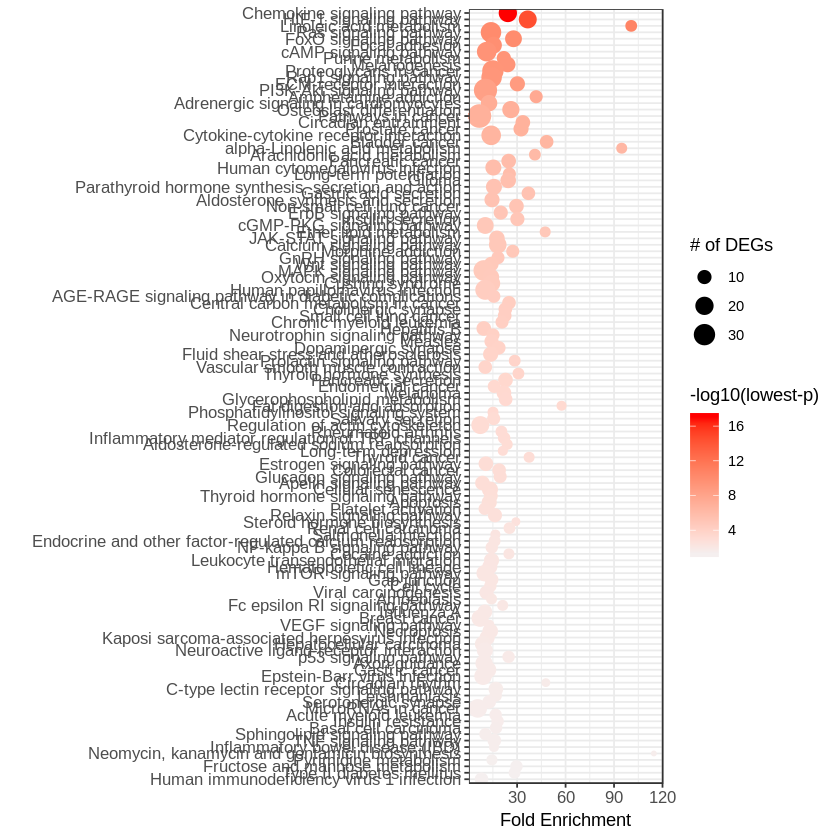



|ID       |Pathway                     | Fold_Enrichment| occurrence| lowest_p| highest_p|Up_regulated                                       |Down_regulated                                                                            | Cluster|Status         |
|:--------|:---------------------------|---------------:|----------:|--------:|---------:|:--------------------------------------------------|:-----------------------------------------------------------------------------------------|-------:|:--------------|
|hsa04062 |Chemokine signaling pathway |        24.26455|         10|        0|         0|PPBP, CXCL9, PF4, CCL18, CCL25, JAK3, GNAI1, TIAM1 |CCL17, CCL22, CCL28, CXCR4, HCK, FGR, RAF1, MAP2K1, CHUK, NCF1, GRK1, ARRB2               |       1|Representative |
|hsa04066 |HIF-1 signaling pathway     |        36.59043|         10|        0|         0|EGF, ERBB2, RPS6, EPO, ANGPT2, HK1                 |TLR4, IFNGR1, INSR, MAP2K1, CYBB, PRKCG, CAMK2D, CAMK2B, VEGFA, EDN1, HK3, PFKF



|    |ID       |Pathway                                         | Fold_Enrichment| occurrence|  lowest_p| highest_p|Up_regulated                                                           |Down_regulated                                                                                 | Cluster|Status         |
|:---|:--------|:-----------------------------------------------|---------------:|----------:|---------:|---------:|:----------------------------------------------------------------------|:----------------------------------------------------------------------------------------------|-------:|:--------------|
|1   |hsa04062 |Chemokine signaling pathway                     |        24.26455|         10| 0.0000000| 0.0000000|PPBP, CXCL9, PF4, CCL18, CCL25, JAK3, GNAI1, TIAM1                     |CCL17, CCL22, CCL28, CXCR4, HCK, FGR, RAF1, MAP2K1, CHUK, NCF1, GRK1, ARRB2                    |       1|Representative |
|3   |hsa00591 |Linoleic acid metabolism                        |   

The maximum average silhouette width was 266 for k = 10 




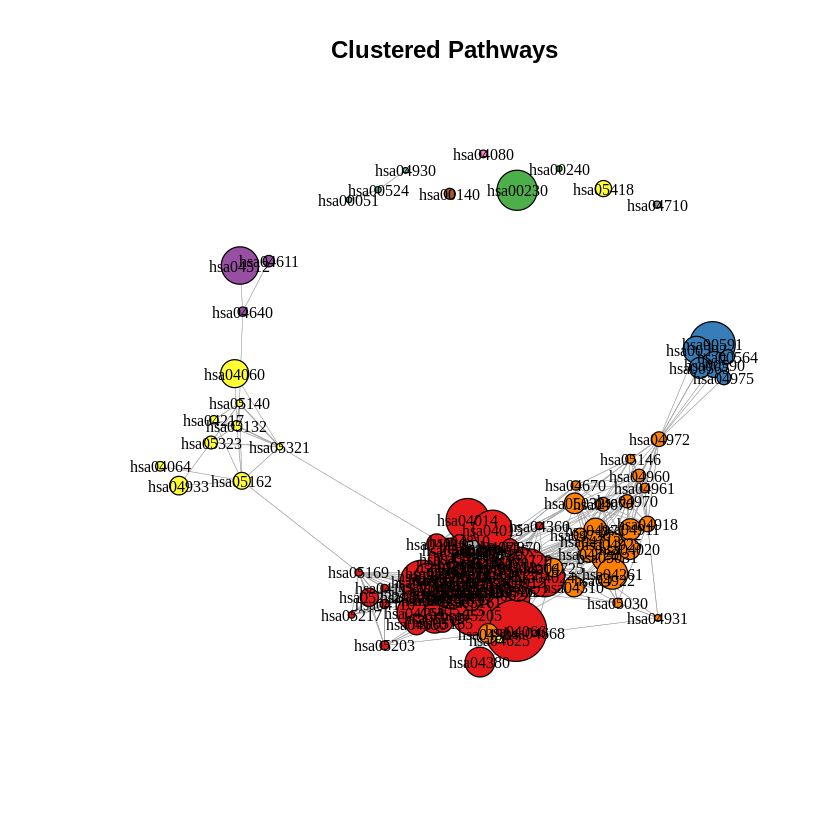

The maximum average silhouette width was 266 for k = 10 




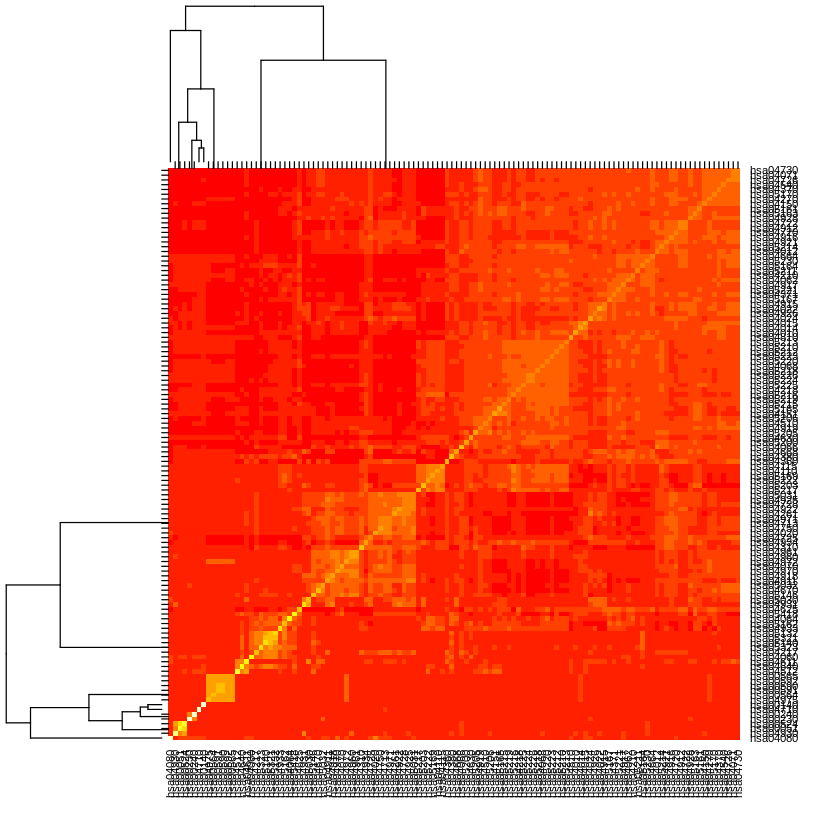

Warning message in if (a != "") {:
“the condition has length > 1 and only the first element will be used”Warning message in rownames(exp_mat)[i] <- a:
“number of items to replace is not a multiple of replacement length”Warning message in if (a != "") {:
“the condition has length > 1 and only the first element will be used”Warning message in rownames(exp_mat)[i] <- a:
“number of items to replace is not a multiple of replacement length”Warning message in if (a != "") {:
“the condition has length > 1 and only the first element will be used”Warning message in rownames(exp_mat)[i] <- a:
“number of items to replace is not a multiple of replacement length”

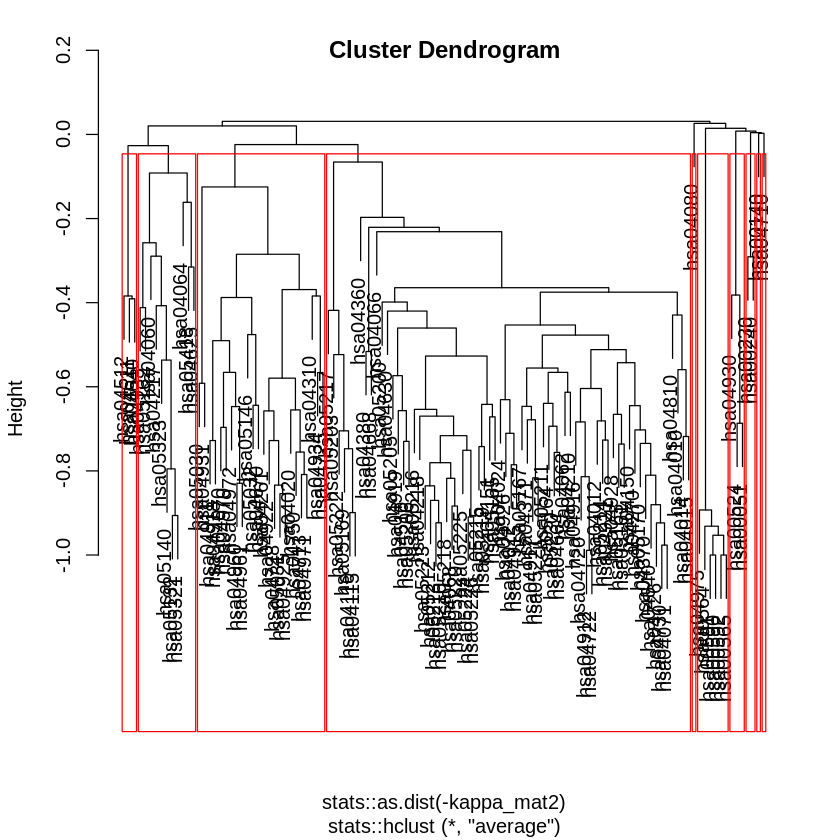

In [34]:
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
genes <- res$row
genes <- gsub("\\..*","",genes )
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id",
                                                          "hgnc_symbol"),values=genes,mart= mart)
for (i in 1:length(genes)){
  if (genes[i] %in% G_list$ensembl_gene_id){
    a = G_list[G_list$ensembl_gene_id == genes[i],]$hgnc_symbol
    if (a != ""){
      res$row[i] = a
    }
    
  }
}

res_mart = res[,c(1,3,7)]
colnames(res_mart)= c("Gene.symbol","logFC","adj.P.Val")

res_mart_na = as.data.frame(na.omit(res_mart))
res_mart_na$adj.P.Val = as.numeric(as.character(res_mart_na$adj.P.Val))

suppressPackageStartupMessages(library(pathfindR))

knitr::kable(head(res_mart_na))
#RA_output <- run_pathfindR(res_mart_na, pin_name = "KEGG", gene_sets = "KEGG", search_method = "SA")
RA_output <- run_pathfindR(res_mart_na, pin_name = "KEGG", gene_sets = "KEGG")
knitr::kable(head(RA_output, 2))

RA_clustered <- cluster_pathways(RA_output)
knitr::kable(head(RA_clustered, 2))
knitr::kable(RA_clustered[RA_clustered$Status == "Representative", ])
RA_clustered <- cluster_pathways(RA_output, plot_hmap = TRUE, plot_clusters_graph = FALSE)
RA_clustered <- cluster_pathways(RA_output, plot_dend = TRUE, plot_clusters_graph = FALSE)

## Pathway scores per samples
## Pathway data frame
pws_table <- RA_clustered
pws_table <- pws_table[pws_table$Status == "Representative", ]


## Expression matrix
  goi <- rownames(res_IF)
stopifnot(all(goi %in% names(ds_IF)))
exp_mat <- log2((counts(ds_IF[goi, ], normalized=TRUE, replaced=FALSE)+.5))

colnames(exp_mat) = colnames(df_IF)

mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
genes <- rownames(exp_mat)
genes <- gsub("\\..*","",genes )
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id",
                                                          "hgnc_symbol"),values=genes,mart= mart)
for (i in 1:length(genes)){
  if (genes[i] %in% G_list$ensembl_gene_id){
    a = G_list[G_list$ensembl_gene_id == genes[i],]$hgnc_symbol
    if (a != ""){
      rownames(exp_mat)[i] = a
    }
    
  }
}





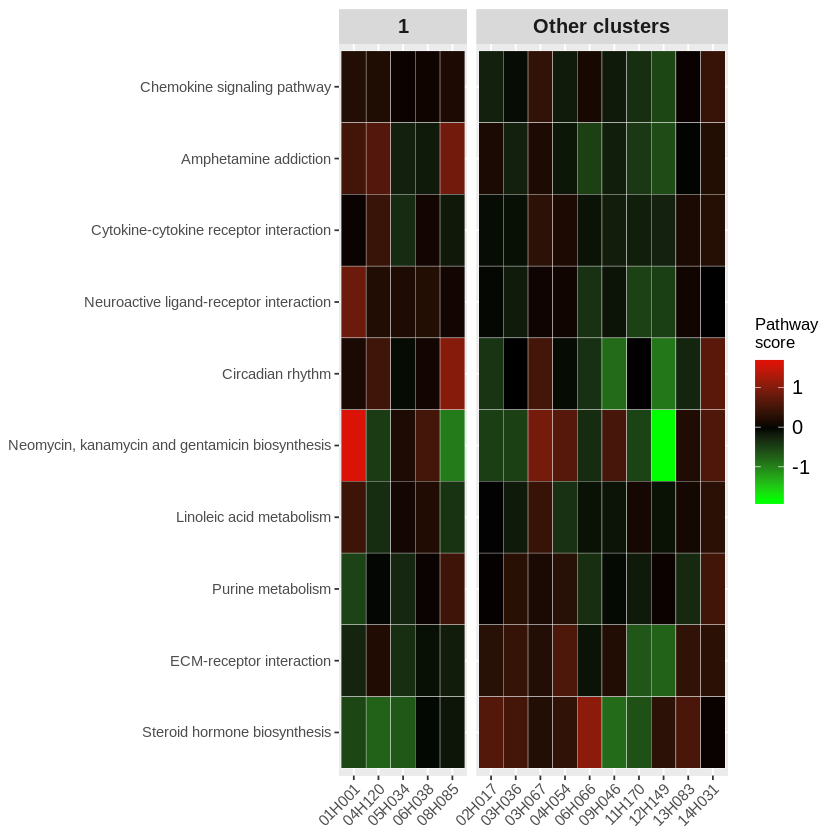

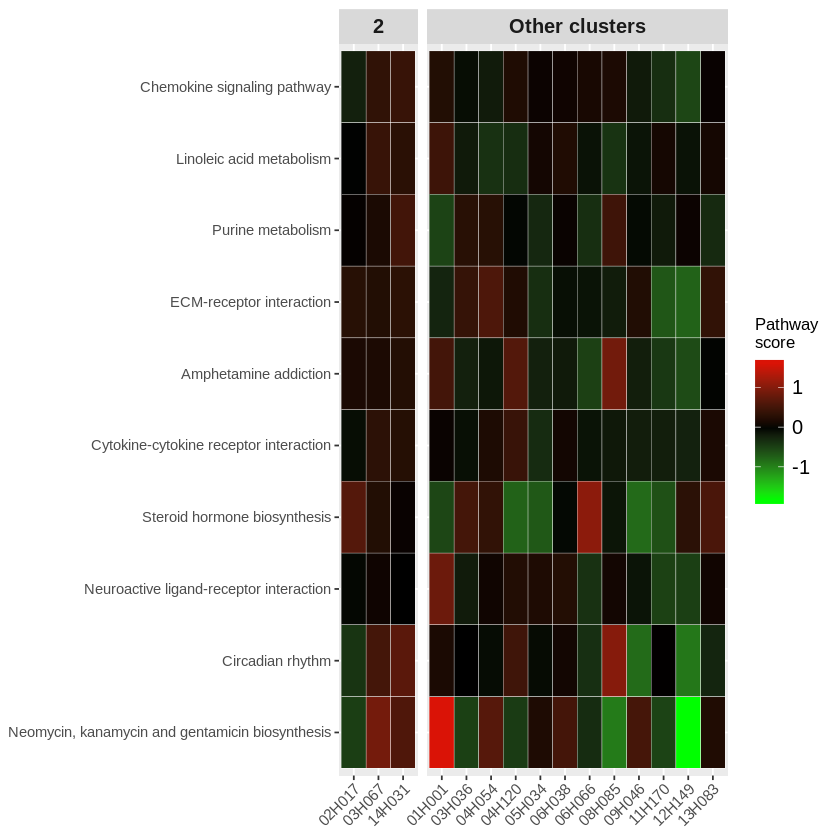

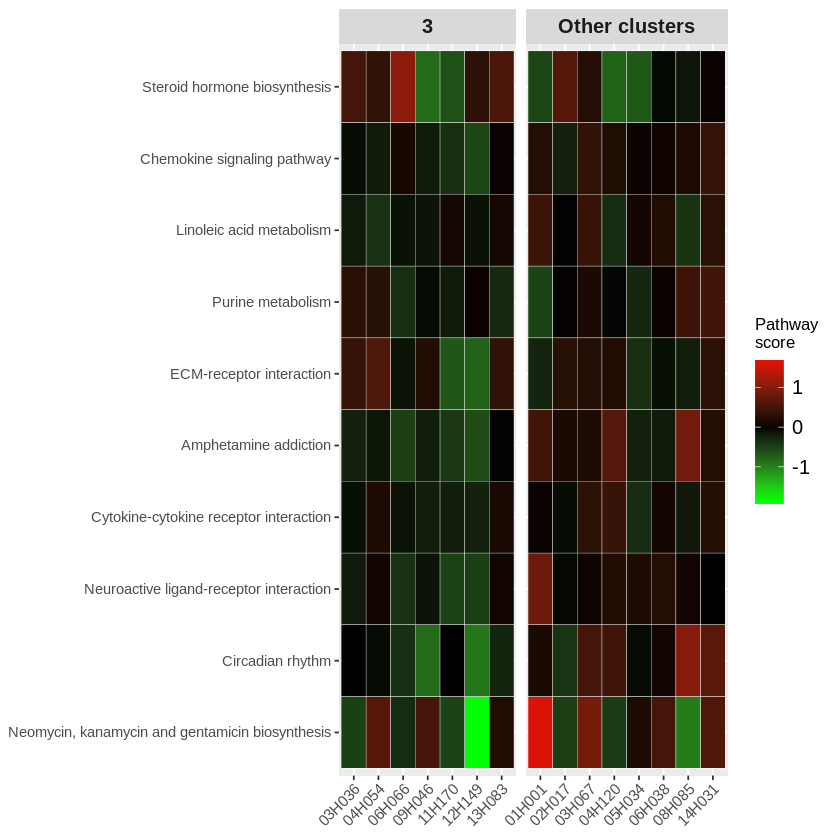

In [35]:

for (i in 1:3){
## Vector of "Case" IDs
cases <- names(pam_fit$clustering[which(pam_fit$clustering == i)])

## Calculate pathway scores and plot heatmap
score_matrix <- calculate_pw_scores(pws_table, exp_mat, cases, case_control_titles = c(i, "Other clusters"))
}